---
title: Geosphere Data Download
date: 2025-04-08
categories: [python-package, data-download]
image: "temp_crop.png"
description: "Python package for downloading meteorological data of stations by Geosphere Austria"
---

[{{< bi gitlab >}} Link to Gitlab Repo](https://git.uibk.ac.at/rslab/geospheredl)

## Description
This package is meant to facilitate the download of meteorological data from the Geosphere (formerly ZAMG) Austria [data hub](https://data.hub.geosphere.at/). The data is made freely available under the [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.

::: {.callout-note}
The package relies on asyncio and aiohttp for querying the data and currently can only run successfully in regular python scripts, i.e., it does unfortunately not work when used in jupyter notebooks.
:::


## Downloading data
Here is an example on how to download data for the station in Obergurgl. Batch download funtionality is described [here](https://git.uibk.ac.at/rslab/geospheredl#download)):

```python
from datetime import datetime
from loguru import logger

from geospheredl import GeosphereClient

gclient = GeosphereClient()

# pick a dataset
ds = "/station/historical/klima-v2-1h"

# set a dataset
gclient.set_dataset(ds)

variables = ["tl", "cglo", "ff", "rr", "rf", "sh"]
params = {
    "parameters": variables,
    "start_date": datetime(1995, 1, 1),
    "end_date": datetime(2025, 1, 1),
    "station_id": 66,
}
    
df = gclient.download_station(**params)
df.to_csv("obergurgl.csv")
```

## Visualization

Here is a visualization of the annual temperature distribution based on the downloaded data. The visualization is a slightly adapted version of the [seaborn ridgeplot example](https://seaborn.pydata.org/examples/kde_ridgeplot).

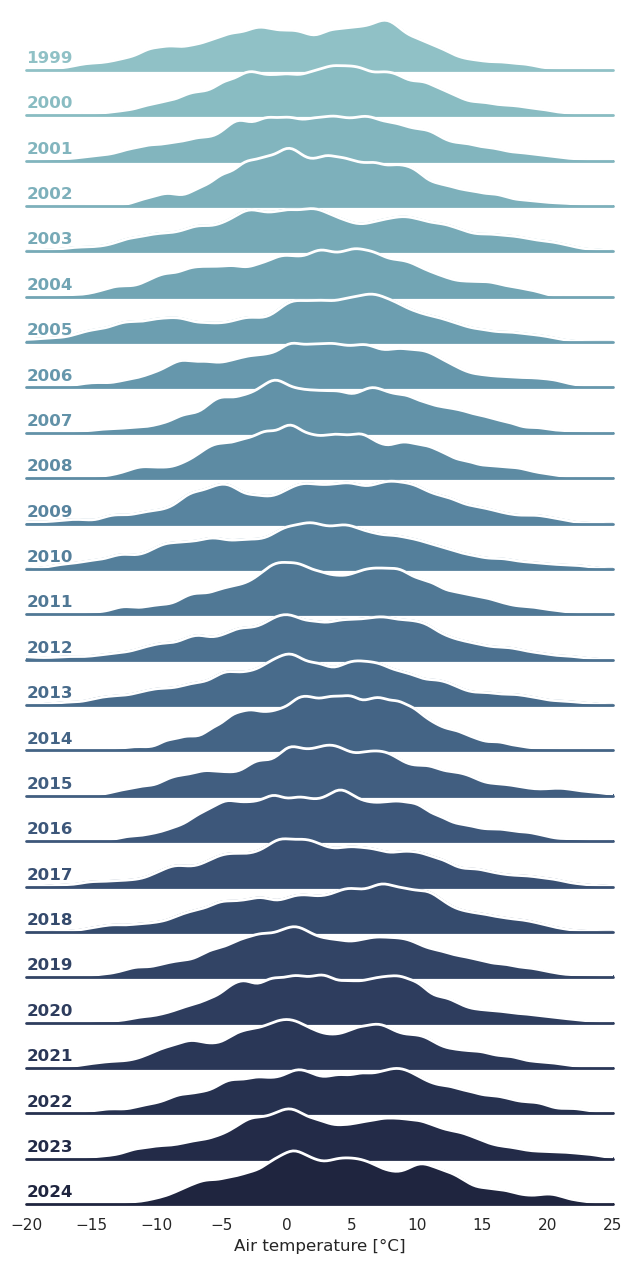

In [1]:
#| code-fold: true
#| fig-cap: "Annual air temperature distribution in Obergurgl (Austria) based on 1-hourly measurements"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("obergurgl.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df[["timestamp", "tl"]]
df = df.dropna(axis="rows")
df["year"] = df["timestamp"].dt.year
df["doy"] = df["timestamp"].dt.day_of_year
df = df.set_index("timestamp")
df = df.loc[df.index < "2025-01-01"]

variable = "tl"

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(len(df["year"].unique()), rot=-0.25, light=0.7)
g = sns.FacetGrid(df, row="year", hue="year", aspect=14, height=0.5, palette=pal)

bw = 0.5

g.map(
    sns.kdeplot, variable, bw_adjust=bw, clip_on=True, fill=True, alpha=1, linewidth=1.5
)
g.map(sns.kdeplot, variable, clip_on=True, color="w", lw=2, bw_adjust=bw)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


def label_ax(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label_ax, "tl")


def set_xlim(color, label, xmin, xmax):
    ax = plt.gca()
    ax.set_xlim((xmin, xmax))


g.map(set_xlim, xmin=-20, xmax=25)

g.figure.subplots_adjust(hspace=-0.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set_xlabels("Air temperature [°C]")

plt.savefig("temp.png", dpi=100, bbox_inches="tight")
plt.show()

::: {.callout-warning}
### Caveats for downloading a lot of data

The geosphere data hub has a limit for the size (i.e., data points) of individual requests and a rate limit for the number of requests. This means it is impossible to download long time series for many different variables in a single request if it exceeds the size limit. Therefore `geospheredl` tries to detect such cases and splits them temporally in a way such that individual requests do not exceed the size limit. Afterwards, the individual pieces of a timeseries are merged again. If `geospheredl` hits the rate limit for requests, it sleeps for the time until the rate limit is reset, which is indicated in the response from the data hub. Generally speaking, this means that downloading a lot of data via `geospheredl` can potentially take a lot of time.
:::
